# BGPDistinct
##### Analyzing BGP messages to classify them as either distinct or duplicated/propagated
*Author: Andy Dolan*

## *Abstract*
This report introduces methodologies to analyze Border Gateway Protocol (BGP) announcement messages with machine learning techniques, with the aim of classifying messages according to whether they belong to a distinct event or are mere propagations of other BGP messages. Neural networks are employed to accomplish this, and classification results are satisfactory when trained on a data set of nearly 11,000 captured BGP announcements.

## Introduction
Border Gateway Protocol (BGP) has been a fundamental component of the Internet for nearly 30 years [1]. The protocol provides automatic worldwide routing between autonomous systems (ASes), allowing network consumers to send packets to a destination by providing nothing more than the destination address. BGP relies on messages broadcast by BGP speakers within ASes that propagate information about how to reach different blocks of addresses in both the IPv4 and IPv6 address spaces. These messages, hereafter referred to as BGP updates, are sent by individual ASes constantly and automatically, so that routing can adapt during outages or congestion. In other words, the interconnected network of ASes is able to adapt to global network conditions, finding shortest paths along which to route consumer packets. As a result, a massive volume of messages are broadcast constantly among ASes, and are rarely seen by network consumers.

In this sense, BGP provides an abstraction that has allowed the Internet to flourish in terms of simplicity; that is, sending a packet anywhere in the world is as simple as knowing the address that it should be sent to. With such a global system that is largely running autonomously at scale, interesting characteristics can be observed when updates are captured, one of which is the number of messages broadcast during a period of time. Listening for the raw number of messages heard by one or more ASes is naïve, in the sense that many messages are only propagations of some original update. Conversely, only a small number of updates are distinct within a time period.

A distinct BGP update is defined here as an update $U$ that has a distinct composite key $C$, consisting of a prefix, prefix mask (e.g., “/24”), and destination AS number associated with it, such that no other update $U’$ that precedes $U$ within the specified time period has the same composite key. The timestamp of the updates comes into play as well, though only for time periods of an appropriate duration.

This report introduces methods with which BGP updates may be classified as distinct or merely propagated for a given time period, using neural networks. The potential benefits to a faithful classification of such messages include a simplified view of which autonomous systems are broadcasting more messages, differentiating between periods of high update creation vs. periods of high update propagation (e.g., “flapping”), and even use in anomaly detection. At the very least, the understanding of normal behaviors of BGP in today’s Internet may be better illustrated by this classification. The section that follows will provide background information on BGP, and subsequent sections will describe the methodology employed and provide examples.

## Background and Related Works
### Border Gateway Protocol
Border Gateway Protocol is used to communicate “network reachability information” among autonomous systems, where an autonomous system is a “set of routers under a single technical administration” [2]. More succinctly, BGP devices listen for update messages and use them to update their internal routing information bases. The information that these tables store is how to forward packets in order to reach a particular address space, so that incoming packets can be routed to the appropriate next hop on the way to their destination. BGP update messages have the capability of announcing and withdrawing advertised routes at the same time, or performing only one or the other [2]. This project only focused on messages that contained at least one advertised route, including messages that also contained withdrawn routes. In other words, messages that contained only withdrawn routes were ignored, and any withdrawals in remaining updates were not analyzed.

The BGP 4 standard [2] specifies that a BGP route announcement contains, among other fields, a prefix and a mask (originally referred to as a “length” in the standard), indicative of the address space to which the announcement pertains. To be clear, the mask represents the number of bits in the address range that remain static. For example, a mask of 8 for an IPv4 address (e.g., “255.0.0.0/8”) would indicate that only the first octet does not change, and therefore the corresponding address space would have 16,777,214 addresses available for use.

The standard also defines an AS_PATH attribute, which is used to track the path of ASes to reach the prefix being announced [2]. The AS_PATH may contain one or more AS_SEQUENCE or AS_SET fields, the former of which is ordered, while the latter is not [2]. This project also only considered BGP messages that maintained the order of their complete AS_PATH. The remainder of this document will refer to the destination AS of an announcement, which is defined as the last AS number found in the last AS_SEQUENCE in the AS_PATH.

As introduced above, this document will also refer to a composite key $C$ for each announcement, which contains the announced prefix, the mask, and the destination AS. These fields were used throughout the project to uniquely identify BGP messages. In practice, when a BGP speaker hears an advertisement, it may prepend its own AS number to the growing AS_PATH, update its own routing table, and propagate the message to its own neighbors [2]. This assumes that the advertisement conforms to any policies that the BGP device has defined, and that the advertised route is considered better than any existing entry in the BGP device’s routing table. Regardless, any propagated message $m$ should share the same composite key $C$ as any other propagated message $m’$, as well as the original message $o$.

### Related Works
Machine learning techniques have been applied to BGP update data in [3], [4], and [5]. However, these techniques were applied in the context of anomaly detection. In [3], Al-Rousan and Trajkovic performed a binary classification on BGP messages, to determine whether any arbitrary message was anomalous or not. Support vector machines and hidden Markov models (the latter is a variation of a neural network) were utilized in [3] on a set of particular features from BGP messages, including the raw number of messages during a time period, and the number of duplicate messages, defined in the paper as “BGP update packets that have identical NLRI prefixes and AS-PATH attributes.” Al-Rousan and Trajkovik [3] found that these “volume features” could be used to accurately classify BGP messages as anomalous. In [4], Ding, Batta, and Trajkovik expand on the previous work in [3] by comparing long short-term memory recurrent neural networks to support vector machines. In both [3] and [4], support vector machines provided better classification accuracy than did the variations on neural networks, though both performed reasonably well. Allahdadi, Mortla, and Prior [5] also utilized support vector machines to perform classification of anomalous BGP messages with particularly relevant features that were extracted.

All three works trained classifiers on sets of anomalous data with supervised learning. All three also included the concept of duplicated messages, based on prefix and path attributes, as input features to their machine learning techniques. These works provide somewhat of a complement to the problem addressed in this project. They investigated using volumetric features to classify BGP messages found during anomalous events, including attacks, while this project focuses on the calculation of a particular volumetric measure of BGP announcements over time, that being whether a BGP announcement is distinct or propagated, to potentially be used in an application such as anomaly detection.

## A Note on Notebook Structure
The core elements of `BGPDistinct` were created as three main Python packages: `preprocessing`, `labeling`, and `learning`. This notebook itself does not contain the code definitions of these packages, but instead imports them from external sources. By default, it is assumed that this notebook is contained in its original directory structure of the BGPDistinct project. If you do not have these code definitions, they can be retrieved from the [repository](https://github.com/adolan5/BGPDistinct) on GitHub. This notebook will hereafter utilize these packages.

In [1]:
import sys
import os
# This assumes that the BGPDistinct codebase is located in ../src
sys.path.append('../src/')

import json
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from preprocessing import *
from learning import NetworkBGP
%matplotlib inline

## Methodologies
### Data Set and Preprocessing
All data for this project was gathered from the [BGPMon](https://www.bgpmon.io/) project’s [public API](http://bgpmon.io/archive/help) [6]. BGPMon is a BGP monitoring system that aggregates and archives captured BGP messages in XML format [6]. The data is available through the public API in a variety of formats and for a wide range of time. Data used for this project was downloaded in JSON format. The data itself contained BGP update messages with the relevant fields described in the introduction, as well as several others described in [2]. Most implementation steps were performed on a particular data set that spanned one minute, from 20:22 to 20:23 UTC on November 15th, 2018. This data can be retrieved with the `get_data` bash script found in the data directory (assumes `cURL` or `Wget`).

In [2]:
# Get data if it is not already present
!bash ../data/get_data.sh

Using cURL
File ../data/raw_one_min_nov15.json already exists. Aborting.


In order to process the data, a `preprocessing` package was created and the `DataFormatter` class was implemented and used to include only well-formed updates that had necessary characteristics for analysis.

In [4]:
df = DataFormatter('../data/raw_one_min_nov15.json')

In [5]:
print('Total number of messages from file:', df.get_num_messages())
print('Number of malformed messages from file:', df.num_malformed)
print('Number of withdraw-only messages from file:', df.num_withdraws)
print('Number of messages containing an AS_SET:', df.num_as_set)
print('Number of announcements from file:', len(df.formatted_data))
print('\nExample of a formatted BGP announcement update:')
print(df.formatted_data[0])

Total number of messages from file: 7235
Number of malformed messages from file: 19
Number of withdraw-only messages from file: 529
Number of messages containing an AS_SET: 0
Number of announcements from file: 6706

Example of a formatted BGP announcement update:
{'mrt_header': {'type': 16, 'subtype': 4, 'len': 170, 'timestamp': 1542313320}, 'bgp4mp_header': {'peer_as': 63956, 'local_as': 6447, 'address_family': 2, 'peer_ip': '2402:1b80::1', 'local_ip': '2001:468:d01:33::80df:330f'}, 'bgp_header': {'marker': '/////////////////////w==', 'length': 126, 'type': 2}, 'bgp_update': {'advertized_routes': [{'prefix': '2620:0:2f0::', 'mask': 48}], 'attrs': {'optional_bit': True, 'extended_bit': True, 'as_path': [{'as_seq': [63956, 4637, 174, 32629]}], 'communities': {'communities': [{'community': 'Eh19JRIdfjoSHX74Eh3uGPnUdTD51HU1+dR5GPnUeUA='}, {'extended_community': 'AAL51AAAAZU='}]}, 'types': [1, 2, 8, 16, 14, 3], 'next_hop': '2402:1b80::1'}}}


Of 7,235 of the messages contained in this 60 second time frame, 6,706 were BGP announcements. The remaining messages contained only updates of route withdrawals.

Once the data had been properly formatted, filtered by desirable characteristics, and sorted by its timestamp, key features were extracted by another class, DataExtr. This class was responsible for capturing the fields of primary interest in each BGP announcement, including the timestamp, the prefix, the mask, the destination AS number, and the full path of the announcement. The lattermost field was included only for readability and use during manual labeling. The other fields were chosen for their utility in identifying any announcement as potentially part of the same distinct event. The timestamp is included separate from the composite key due to the fact that it may independently determine whether or not an announcement is a propagation of some previous message vs. a new distinct message. To illustrate this concept, consider the example of an announcement $A$ that shares the same composite key with another announcement $A’$ that was broadcast 24 hours earlier. Given the nature of BGP and the constant stream of messages that are propagated relatively quickly throughout the network, it is unlikely that $A$ is a propagation of $A’$, but that $A$ is rather a propagation of a more recent announcement or is itself a new announcement altogether. Even so, this project did not take the temporal difference of announcements into account, but still used the timestamp as an input to the neural network.

It is also important to note that [2] allows for aggregation of advertised prefixes and masks in a single BGP update, so long as all routes being advertised share the same path (and therefore destination AS number). In order to fully investigate distinct updates, any message that contained $n$ advertised prefixes and masks, where $n > 1$, was considered to be n separate logical announcements, each of which advertised only one prefix and mask, and shared the same AS_PATH and timestamp. For the Nov. 15 data set, this increased the number of announcements to 10,959. This also clearly indicates the fact that announcement aggregation does take place quite frequently in BGP. During runtime, the extracted data was formatted as a Python dictionary, containing a timestamp, a composite key consisting of a prefix, a mask, and a destination AS number, and the full path of the BGP announcement, which had been reconstructed in the case that it was made up of several individual AS_SEQUENCEs. An example of the extracted data is seen in the cell below.

In [6]:
de = DataExtr(df.formatted_data)

In [7]:
print('Example of an extracted message:')
print(json.dumps(de.extracted_data[0], indent=2))
print('\nNumber of extracted single-prefix announcements:', len(de.extracted_data))

Example of an extracted message:
{
  "time": 1542313320,
  "composite": {
    "prefix": "2620:0:2f0::",
    "mask": 48,
    "dest": 32629
  },
  "full_path": [
    63956,
    4637,
    174,
    32629
  ]
}

Number of extracted single-prefix announcements: 10959


## Initial Data Experiments
Once preprocessing had been completed, one of the preliminary investigations into the amount of announcements that are only propagated vs. distinct came in the form of simple experiments performed on the extracted data. These experiments were performed with a larger data set that spanned an hour’s worth of time, containing nearly 255,000 update messages with about 5,000 unique destination AS numbers.

In [8]:
# The previous bash script can be used to download the large data set (warning: 160 MB in size!)
!bash ../data/get_data.sh large

Using cURL
File ../data/raw_large_set_nov1.json already exists. Aborting.


In [9]:
# Perform preprocessing on larger set, timing it
start = time.time()
large_df = DataFormatter('../data/raw_large_set_nov1.json')
format_time = time.time()
large_de = DataExtr(large_df.formatted_data)
end = time.time()

print('Formatting took {} seconds'.format(format_time - start))
print('Extraction took {} seconds'.format(end - format_time))

Formatting took 30.73447895050049 seconds
Extraction took 2.2777435779571533 seconds


In [16]:
print('Total number of messages:', large_df.get_num_messages())
print('Number of malformed messages:', large_df.num_malformed)
print('Number of messages containing an AS_SET:', large_df.num_as_set)
print('Number of valid announcements:', len(large_de.extracted_data))
print('')

# Calculate the number of unique composite keys
unique_composites = set([tuple(s.get('composite').values()) for s in large_de.extracted_data])
print('Number of unique composite keys:', len(unique_composites))
print('{:.2%} of all messages had a distinct composite key.'.format(len(unique_composites) / len(large_de.extracted_data)))

Total number of messages: 268101
Number of malformed messages: 146
Number of messages containing an AS_SET: 298
Number of valid announcements: 692127

Number of unique composite keys: 31428
4.54% of all messages had a distinct composite key.


After preprocessing, the raw number of logical announcements rose to nearly 700,000, even though there were under 35,000 unique prefix, mask, and destination AS combinations, suggesting a high amount of duplication. That suspicion was confirmed when the number of unique composite keys was graphed against the total number of announcements for each minute of the hour, as displayed below. Overall, the number of announcements with unique composite keys made up under 5% of the total number of announcements.

In [18]:
# Set global font size for matplotlib
plt.rcParams.update({'font.size': 12})

# Get the number of unique composite keys for each minute of the full hour
# comps_per_min = len(set([tuple(s.get('composite').values()) for s in subset]
def show_duplication(data, interval=10, use_xticks=True):
    """Produce a graph that illustrates how much duplication takes place during
    every interval.
    Args:
    data (list): The data to analyze.
    interval (int): The number of seconds per bucket for which to
        collect messages.
    use_xticks (bool): Whether or not to label each interval of
        the resulting graph.
    """
    comps_per_int = []
    messages_per_int = []
    start_time = data[0].get('time')
    end_time = data[-1].get('time')
    for i in range((end_time -start_time) // interval):
        bucket_start = start_time + (interval * i)
        bucket_end = bucket_start + interval
        all_comps = [tuple(s.get('composite').values())
                            for s in data if bucket_start <= s.get('time') < bucket_end]
        comps_per_int.append(len(set(all_comps)))
        messages_per_int.append(len(all_comps))

    # Create and label the chart
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 8)
    plt.xticks(rotation=90)
    plt.tick_params(bottom=use_xticks, labelbottom=use_xticks)
    plt.title('Duplication of BGP Announcements over {} seconds, {} Second Intervals'.format((end_time - start_time), interval))
    plt.xlabel('Interval ({} seconds each)'.format(interval))
    plt.ylabel('Number of messages')
    
    # Create bars and legend
    interval_labels = [str(x) for x in range(len(messages_per_int))]
    all_bar = ax.bar(interval_labels, messages_per_int)
    unique_bar = ax.bar(interval_labels, comps_per_int)
    plt.legend([all_bar, unique_bar], ['All messages', 'Unique composite keys'])
    plt.show()

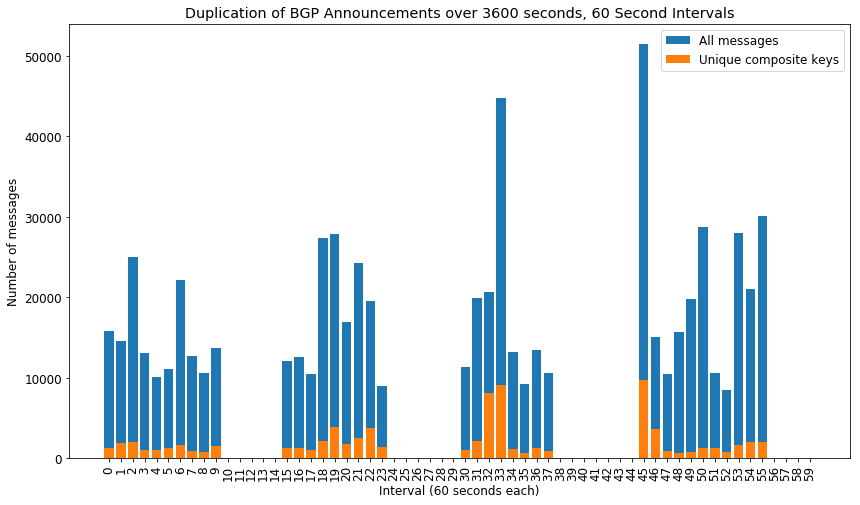

In [19]:
show_duplication(large_de.extracted_data, 60)

Clearly, there are many BGP announcements that are propagated. It may be the case that some of these messages are actually results of reannouncements (i.e., announcements that were made at a later time). We can see that this property holds at a more fine grained time interval such as every 10 seconds.

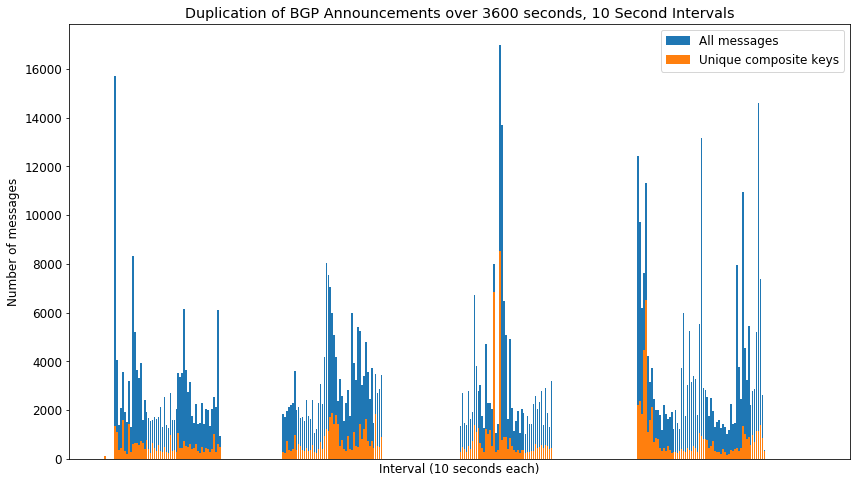

In [20]:
show_duplication(large_de.extracted_data, 10, use_xticks=False)

We can also see the same behavior in the smaller, minute-long data set. A similar ratio of distinct composite keys to total messages was calculated at 7%, with 774 unique composite keys to in the 10,959 total announcements.

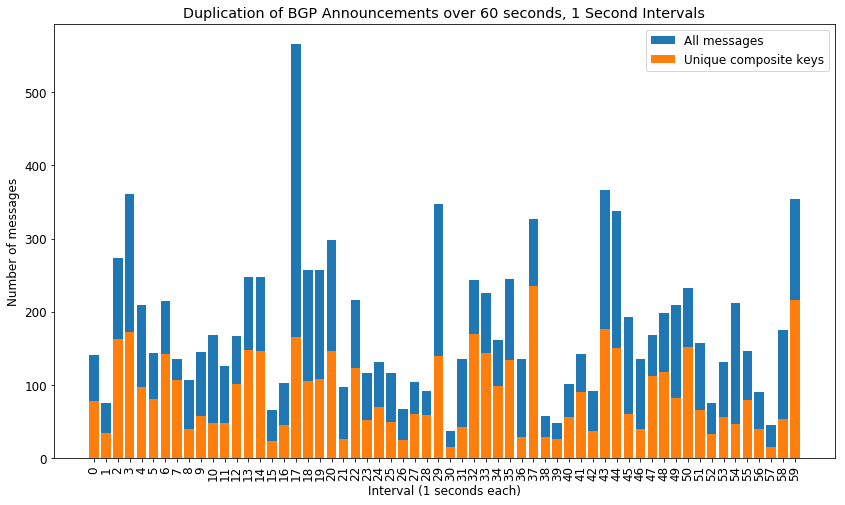

In [21]:
show_duplication(de.extracted_data, 1)

In [28]:
unique_composites = set([tuple(s.get('composite').values()) for s in de.extracted_data])
print('{:.2%} of all messages had a distinct composite key.'.format(len(unique_composites) / len(de.extracted_data)))

7.06% of all messages had a distinct composite key.


### Data Experiments
What's the total number of messages, when considering each advertised prefix as a single message?

In [3]:
len(full)

10959

What's the number of unique prefixes?

In [4]:
len(set([f.get('composite').get('prefix') for f in full]))

675

What's the number of unique destinations?

In [5]:
len(set([f.get('composite').get('dest') for f in full]))

201

What's the number of unique composite keys (prefix, mask, destination)?

In [6]:
num_unique_comp = len(set([tuple(f.get('composite').values()) for f in full]))
print(num_unique_comp)
print('{:.2%} of all messages have a unique composite key'.format(num_unique_comp / len(full)))

774
7.06% of all messages have a unique composite key


How many unique composite keys were there every 10 seconds, vs. the number of total announcements?

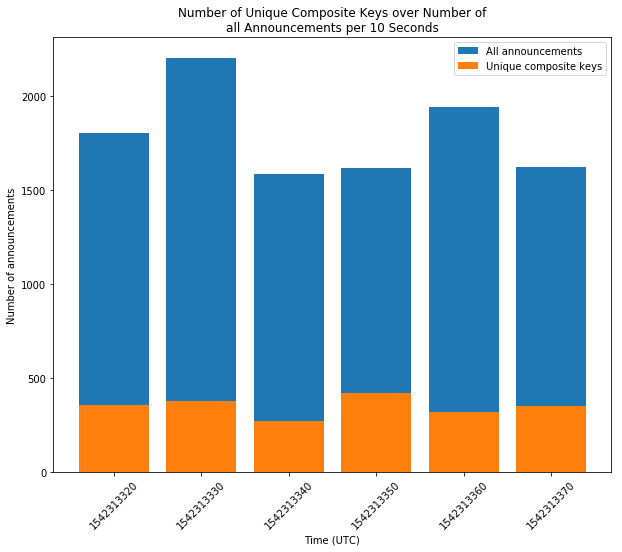

In [7]:
composites_on_tens = []
times = []
for t in range(full[0].get('time'), full[-1].get('time'), 10):
    times.append(str(t))
    composites_on_tens.append([tuple(s.get('composite').values()) for s in full if t <= s.get('time') < t + 10])

full_bars = [len(s) for s in composites_on_tens]
unique_bars = [len(set(s)) for s in composites_on_tens]
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.xlabel('Time (UTC)')
plt.ylabel('Number of announcements')
plt.title('Number of Unique Composite Keys over Number of\nall Announcements per 10 Seconds')
full_bars = ax.bar(times, full_bars)
unique_bars = ax.bar(times, unique_bars)
plt.legend((full_bars, unique_bars), ('All announcements', 'Unique composite keys'))
fig.set_size_inches(10, 8)
plt.show()

## Creating a Network
The network utilized for distinguishing distinct BGP messages was relatively simple, but maintained a surprisingly high accuracy when classifying data. The network consisted of three linear layers, each paired with a ReLU activation function, followed by a final linear layer paired with the LogSoftmax function (for use with the NLLLoss loss funciton).

The hidden layers in the network also consist of a large number of neurons, to extrapolate on the relationships between input features.

In [45]:
net_manager = NetworkBGP(full, n_hidden=2, n_neurons=10, lr=0.0005, cw=[0.08, 1], force_cpu=False)
# Note that if a GPU is available, we'll be using it:
if torch.cuda.is_available():
    !nvidia-smi

Fri Dec  7 20:04:08 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:03:00.0 Off |                  N/A |
|  6%   59C    P2    27W / 150W |    309MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [46]:
net_manager.net

DistinctNN(
  (h0): Linear(in_features=4, out_features=10, bias=True)
  (a0): ReLU()
  (hidden_sequence): Sequential(
    (h1): Linear(in_features=10, out_features=10, bias=True)
    (a1): ReLU()
    (h2): Linear(in_features=10, out_features=10, bias=True)
    (a2): ReLU()
  )
  (raw_out): Linear(in_features=10, out_features=2, bias=True)
  (out_act): LogSoftmax()
)

In [47]:
net_manager.Xtrain[:3]

tensor([[-1.6607,  2.6270,  1.3783, -0.4380],
        [-1.6607,  2.6315,  0.3204,  1.4533],
        [-1.6607, -0.3896, -0.2085,  1.3688]],
       device='cuda:0', dtype=torch.float64)

## Training the Network

In [48]:
start = time.time()
losses = net_manager.train_network(num_iterations=6000)
print('Training took {}'.format(time.time() - start))

Training took 16.72361397743225


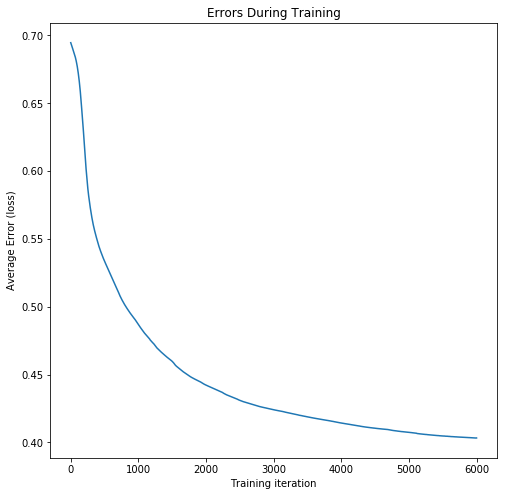

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.plot(losses)
plt.ylabel('Average Error (loss)')
plt.xlabel('Training iteration')
plt.title('Errors During Training')
plt.show()

In [50]:
losses[-1]

[tensor(0.4032, device='cuda:0', dtype=torch.float64)]

## Testing the Network
### Data used for Training

In [51]:
alpha=0.1

In [52]:
predicted = net_manager.get_predicted_classes(net_manager.net(net_manager.Xtrain))
actual = net_manager.Ttrain.cpu().numpy().flatten()

In [53]:
predicted

array([1, 1, 1, ..., 0, 1, 1])

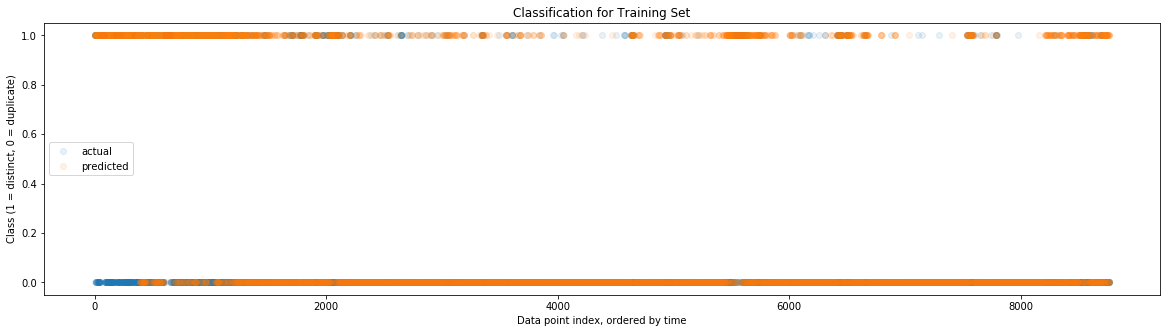

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Training Set')
plt.show()

In [55]:
net_manager.get_correct(predicted, actual)

(0.8074817518248175, 0.8069848371861794, 0.8130193905817175)

In [56]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 80.75%
% of duplicate messages correctly classified: 80.70%
% of distinct messages correctly classified distinct: 81.30%


### On New Data

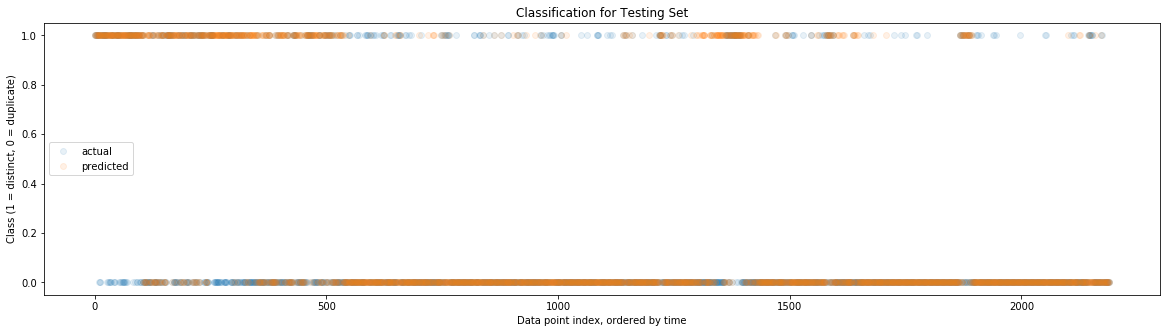

In [57]:
predicted = net_manager.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.cpu().numpy().flatten()
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Testing Set')
plt.show()

In [58]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 79.37%
% of duplicate messages correctly classified: 82.36%
% of distinct messages correctly classified distinct: 67.06%


In [29]:
all_overall = []
all_duplicate = []
all_distinct = []
for i in range(10):
    print('Iteration', i)
    net_manager = NetworkBGP(full, n_hidden=2, n_neurons=10, lr=0.0005, cw=[0.08, 1], force_cpu=False)
    net_manager.train_network(num_iterations=6000)
    predicted = net_manager.get_predicted_classes(net_manager.net(net_manager.Xtest))
    actual = net_manager.Ttest.cpu().numpy().flatten()
    
    all_ratios = net_manager.get_correct(predicted, actual)
    all_overall.append(all_ratios[0])
    all_duplicate.append(all_ratios[1])
    all_distinct.append(all_ratios[2])

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [59]:
print('Overall average accurracy: {:.2%}'.format(np.mean(all_overall)))
print('Average duplicate ann. accuracy: {:.2%}'.format(np.mean(all_duplicate)))
print('Average distinct ann. accuracy: {:.2%}'.format(np.mean(all_distinct)))

Overall average accurracy: 78.26%
Average duplicate ann. accuracy: 82.91%
Average distinct ann. accuracy: 58.89%


## References

[1] K. Lougheed and Y. Rekhter, "A Border Gateway Protocol (BGP)," RFC 1105, Jun. 1989, Available: https://tools.ietf.org/html/rfc1105  

[2] Y. Rekhter, T., Li, and S. Hares, “A Border Gateway Protocol 4 (BGP-4),” RFC 4271, Jan. 2006, Available: https://tools.ietf.org/html/rfc4271#section-5.1.2    

[3] N. M. Al-Rousan and L. Trajkovic, “Machine Learning Models for Classification of BGP Anomalies,” in 2012 IEEE 13th International Conference on High Performance Switching and Routing, 2012, pp. 103-108, Available: https://ieeexplore.ieee.org/document/6260835 

[4] Q. Ding, Z. Li, P. Batta, and L. Trajkovic, “Detecting BGP Anomalies Using Machine Learning Techniques,” in 2016 IEEE International Conference on Systems, Man, and Cybernetics (SMC), 2016, pp. 003352-003355 Available: https://ieeexplore.ieee.org/document/7844751 

[5] A. Allahdadi, R. Mortla, and R. Prior, “A Framework for BGP Abnormal Events Detection,” ArXiv:1708.03453, Aug. 2017, Available: https://arxiv.org/abs/1708.03453  

[6] BGPMon, “About BGPMonitoring System,” [Online]. Available: https://www.bgpmon.io/about.html  

[7] “Torch.NN,” PyTorch Master Documentation, [Online]. Available: https://pytorch.org/docs/stable/nn.html  

[8] D. P. Kingma and J. L. Ba, “Adam: A Method for Stochastic Optimization,” ArXiv:1412.6980, May 2015, Available: https://arxiv.org/abs/1412.6980

In [26]:
import io
from nbformat import current
import glob
nbfile = glob.glob('BGPDistinct.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file BGPDistinct.ipynb is 2531


### In Review: Data
The data to be analyzed had already been properly formatted and had relevant features extracted. In all, each representation of a BGP message contained a timestamp, the full path of the message (i.e., each AS number in the path to the final destination AS), and the composite key, consisting of the announced prefix, the prefix mask, and the final destination AS number. Only the timestamp and fields held in the composite key were used as inputs to the neural network, while the full AS path was kept as a convenience for data experimentation.

### A Note about Labeling
Note that data was only labeled upon partitioning, as different partitions neccessitate different labels for each datapoint therein. That is, labeling the data before partitioning could result in incorrectly labled inputs after partitioning. Consider the example that a message that is a duplicate of only one other message that came before it is moved to the test partition, and no duplicate message precedes it, and the message should therefore be considered distinct.

A naive labeling scheme was chosen for the purposes of this project, due to time constraints and realistic need of more complex labeling. Specifically, the labeling scheme did not take temporal difference into account. For the datasets used during training, this likely did not have a great impact, as time periods spanned a minute, at most. Still, labeling remains one of the biggest challenges to be addressed in future work.